## 확률적 경사 하강법
- 점진적 학습 (step, 보폭)
- 학습률
- XGBoost, LightGBM, 딥러닝(이미지 분류, 자연어 처리, 옵티마이저)

### 
- 신경망 이미지 데이터, 자연어
- 자율주행 하루 데이터 1TB --> 학습
- 한꺼번에 다 모델을 학습 어려움
  + 샘플링, 배치, 에포크, 오차(=손실=loss)가 가장 작은 지점을 찾아야 함. 
- 결론적으로, 확률적 경사 하강법

### 손실함수
- 로지스틱 손실 함수


In [22]:
import pandas as pd 
fish = pd.read_csv("https://bit.ly/fish_csv_data")
fish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   159 non-null    object 
 1   Weight    159 non-null    float64
 2   Length    159 non-null    float64
 3   Diagonal  159 non-null    float64
 4   Height    159 non-null    float64
 5   Width     159 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB


- 입력 데이터와 타깃 데이터 분리

In [23]:
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()
fish_target = fish['Species'].to_numpy()

fish_input.shape, fish_target.shape

((159, 5), (159,))

- 훈련 세트와 테스트 데이터 분리

In [24]:
from sklearn.model_selection import train_test_split 
train_input, test_input, train_target, test_target = train_test_split(
    # input, target, 옵션... 
    fish_input, fish_target, random_state=42
)

- 훈련 세트와 테스트 세트의 특성 표준화
  + 무게, 길이, 대각선 길이, 높이, 너비 
- 표준화 처리 진행
  

In [25]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

# train_scaled[:5]

## 모델링
- 확률적 경사 하강법 

In [26]:
from sklearn.linear_model import SGDClassifier 
sc = SGDClassifier(loss = 'log', max_iter = 10, random_state=42)

sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.773109243697479
0.775


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


- partial_fit() 메서드 사용하면 추가 학습. 

In [27]:
sc.partial_fit(train_scaled, train_target) 
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.8151260504201681
0.85


## 에포크와 과대/과소적합
- 에포크 숫자가 적으면 --> 덜 학습
- early_stopping
  + 에포크 숫자를 1000, 손실 10, 9, 8, , 3
  + 3에 도달한 시점이 150 

In [28]:
import numpy as np 
sc = SGDClassifier(loss='log', random_state = 42)
train_score = []
test_score = []

classes = np.unique(train_target)

# 300번 에포크 훈련을 반복
# 훈련 할 때마다, train_score, test_score 추가를 한다. 
for _ in range(0, 300):
  sc.partial_fit(train_scaled, train_target, classes = classes)
  train_score.append(sc.score(train_scaled, train_target))
  test_score.append(sc.score(test_scaled, test_target)) 


- 시각화 

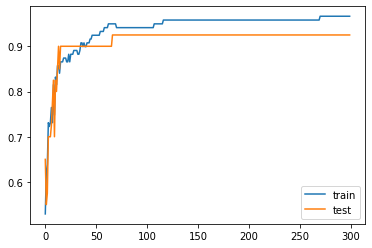

In [29]:
import matplotlib.pyplot as plt 
plt.plot(train_score)
plt.plot(test_score)
plt.legend(["train", "test"])
plt.show()

## 결정트리
- wine 데이터 가져오기

In [30]:
import pandas as pd 
wine = pd.read_csv('https://bit.ly/wine_csv_data')
print(wine.head())

   alcohol  sugar    pH  class
0      9.4    1.9  3.51    0.0
1      9.8    2.6  3.20    0.0
2      9.8    2.3  3.26    0.0
3      9.8    1.9  3.16    0.0
4      9.4    1.9  3.51    0.0


- 데이터 가공하기 

In [31]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

- 훈련데이터 분리

In [32]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size = 0.2, random_state=42
)

train_input.shape, test_input.shape, train_target.shape, test_target.shape

((5197, 3), (1300, 3), (5197,), (1300,))

- 표준화 처리

In [33]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

- 모델 만들기

0.9003271117952665
0.8576923076923076


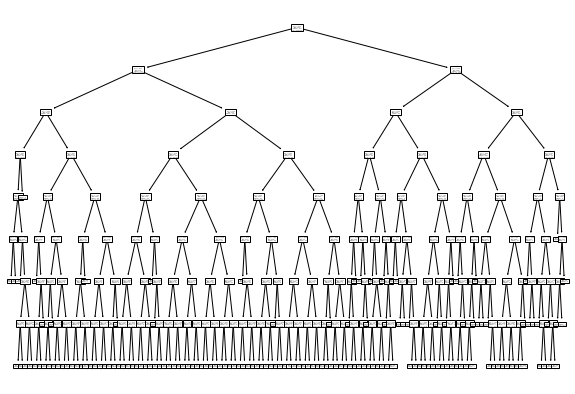

In [34]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt 
from sklearn.tree import plot_tree 

# dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, random_state=42) 엔트로피
dt = DecisionTreeClassifier(max_depth = 8, random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))

plt.figure(figsize=(10, 7))
plot_tree(dt)
plt.show()

- 훈련 정확도는 99.6%
- 테스트 정확도는 85.9% 
--> 과대적합이 일어남

### 노드 

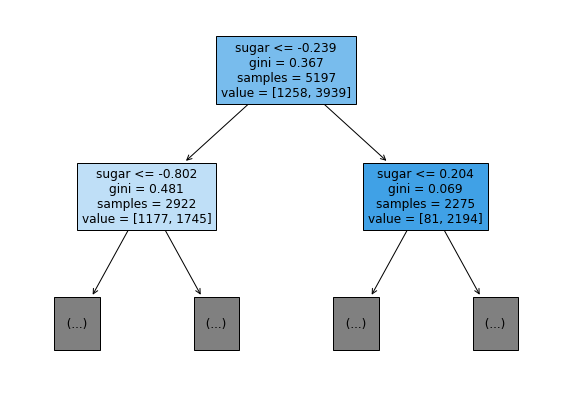

In [35]:
plt.figure(figsize=(10,7))
plot_tree(dt,
          max_depth = 1, # 깊이 
          filled=True,
          feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

### 조건
- 첫번째 조건은 조건들 중 가장 확실하게 분류되는 조건이 온다.
- 지시 함수를 기반으로 조건식을 구한다.

### 명칭
- 맨위 = 루트노드(뿌리노드)
- 중간 = 노드
- 제일 마지막 = 리프노드(말단노드)
- 깊이 = 조건식 갯수

- 불순도 
  - 한 범주 안에서 서로 다른 데이터가 얼마나 섞여 있는지 나타냄
  - 비율이 5:5일때 : 불순도 최대, gini 불순도 수치 = 0.5
  - 100% 분리 되었을때 :불순도 최소, gini 분순도 수치 = 0
- 엔트로피(Entropy)
  - 불확실한 정도를 의미
  - 0 ~ 1
    - 비율이 5:5일때 엔트로피 최대 = 1
    - 100% 분리 되었을때 엔트로피 최소 = 0

### 특성 중요도
- 어떤 특성이 결정 트리 모델에 영향을 주었는가

In [36]:
print(dt.feature_importances_)

[0.17976778 0.65284899 0.16738324]


### 검증 세트
- 훈련세트와 테스트세트
- 훈련 : 교과서를 공부하는 것 훈련세트, 모의평가
- 검증 : 강남대성 모의고사
- 테스트 : 6월/9월 모의고사


In [42]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

wine = pd.read_csv('https://bit.ly/wine_csv_data')
print(wine.head())

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size = 0.2, random_state=42
)

train_input.shape, test_input.shape, train_target.shape, test_target.shape

   alcohol  sugar    pH  class
0      9.4    1.9  3.51    0.0
1      9.8    2.6  3.20    0.0
2      9.8    2.3  3.26    0.0
3      9.8    1.9  3.16    0.0
4      9.4    1.9  3.51    0.0


((5197, 3), (1300, 3), (5197,), (1300,))

In [48]:
# 훈련 80
# 검증 20

sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state = 42)
print(sub_input.shape, val_input.shape)

(4157, 3) (1040, 3)


In [52]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print("훈련성과:", dt.score(sub_input, sub_target))
print("검증 성과:", dt.score(val_input, val_target))
print("마지막 최종:", dt.score(test_input, test_target))

훈련성과: 0.9971133028626413
검증 성과: 0.864423076923077
마지막 최종: 0.8569230769230769


- 검증과 최종의 확률이 비슷해야한다.

### 교차 검증
- 데이터 셋을 반복 분할
- 샘플링이 편향적일 수 있음을 방지하기 위해
- 모형을 안정적으로 만들어 준다
 - 과대 적합 방지

In [64]:
import numpy as np
from sklearn.model_selection import KFold

df = np.array([1,2,3,4,5,6,7,8,9,10])

# 데이터를 K폴드로 나눈다
folds = KFold(n_splits=5, shuffle = True)# 교차검증을 몇번할꺼냐
for train_idx, valid_idx in folds.split(df):
  print(f'훈련데이터 :{df[train_idx]}, 검증데이터 : {df[valid_idx]}')

훈련데이터 :[ 1  2  3  4  6  7  8 10], 검증데이터 : [5 9]
훈련데이터 :[1 3 4 5 6 7 8 9], 검증데이터 : [ 2 10]
훈련데이터 :[ 1  2  3  4  5  6  9 10], 검증데이터 : [7 8]
훈련데이터 :[ 2  4  5  6  7  8  9 10], 검증데이터 : [1 3]
훈련데이터 :[ 1  2  3  5  7  8  9 10], 검증데이터 : [4 6]


- 교차 검증 함수 

In [67]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
print(scores)
print("평균:",np.mean(scores['test_score']))

{'fit_time': array([0.01061797, 0.01001596, 0.01057696, 0.01032686, 0.00986886]), 'score_time': array([0.00118041, 0.00118399, 0.00116229, 0.00113297, 0.00111485]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}
평균: 0.855300214703487


- StratifiedKFold 사용 

In [76]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(scores)
print("평균:",np.mean(scores['test_score']))

{'fit_time': array([0.01017427, 0.0070827 , 0.0073967 , 0.00732017, 0.0069654 ]), 'score_time': array([0.00081372, 0.00074744, 0.0007174 , 0.00073171, 0.00071931]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}
평균: 0.855300214703487


- 10폴드 교차 검증을 수행

In [77]:
from sklearn.model_selection import StratifiedKFold
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # n_splits는 몇 폴드 교차 검증을 할지 정의
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(scores)
print("평균:",np.mean(scores['test_score']))

{'fit_time': array([0.01029015, 0.00815034, 0.00902534, 0.00820923, 0.0081687 ,
       0.00809574, 0.0080421 , 0.00797629, 0.00809836, 0.00793672]), 'score_time': array([0.00072193, 0.00066876, 0.00071168, 0.00066352, 0.00067019,
       0.0006609 , 0.00063467, 0.00062871, 0.00067377, 0.0006659 ]), 'test_score': array([0.83461538, 0.87884615, 0.85384615, 0.85384615, 0.84615385,
       0.87307692, 0.85961538, 0.85549133, 0.85163776, 0.86705202])}
평균: 0.8574181117533719


## 하이퍼파라미터 튜닝
- 그리드 서치
  - 사람이 수동적으로 입력
- 랜덤 서치
  - 사람이 범위만 지정
- 베이지안 옵티마이제이션(bayesian optimization)
- AutoML : 사람의 개입 없이 하이퍼파라미터 튜닝을 자동으로 수행
  - ex) pycaret
- 각 모델마다 적게는 1-2개에서, 많게는 5-6개의 매개 변수를 제공한다
  - XGBoost 경우 100개정도가 있다
- 하이퍼파라미터와 동시에 교차검증을 수행
  - 미친짓이다



In [85]:
from sklearn.model_selection import GridSearchCV
params={
    'max_depth' : [1,3,7],
    'min_impurity_decrease':[0.0001,0.0002,0.0003,0.0004,0.0005]
}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params,n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 7],
                         'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [86]:
print("best:", gs.best_estimator_)
dt = gs.best_estimator_

best: DecisionTreeClassifier(max_depth=7, min_impurity_decrease=0.0005,
                       random_state=42)
